<a href="https://colab.research.google.com/github/wyctorfogos/DarkNet---Classifier-PyTorch-/blob/main/Darknet_19_classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.optim import Adam, SGD, RMSprop
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(17)

In [2]:
transformations = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [48]:
from torchvision.datasets.fakedata import transforms

train= datasets.CIFAR10(root='data', download=True, train=True, transform=transformations)
test= datasets.CIFAR10(root='data',download=True, train=False, transform=transformations)

#train = datasets.VOCDetection(root= './data', year = '2012', image_set = 'train', download = True, transform = transformations)
#test = datasets.VOCDetection(root= './data', year = '2012', image_set = 'val', download = True, transform = transformations)

batch=1

dataset_train = DataLoader(train, batch_size=batch, shuffle=True)
dataset_test = DataLoader(test, batch_size=batch, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Test dataset

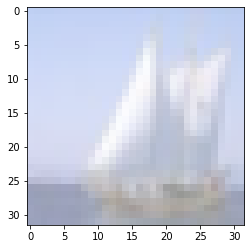

In [49]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(dataset_train)
images, labels = data_iter.next()

def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
plot_images(torchvision.utils.make_grid(images))


del images
del labels

In [50]:
##Darknet-19 model

class BlockConv1(nn.Module):
  def __init__(self, input_channels, output_channels, num_kernel=1, size_stride=1, *kwgars):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch1 = nn.BatchNorm2d(output_channels)
    self.conv2 = nn.Conv2d(output_channels,input_channels, kernel_size=num_kernel, stride=(size_stride), padding=0)
    self.batch2 = nn.BatchNorm2d(input_channels)
    self.conv3 = nn.Conv2d(input_channels,output_channels, kernel_size=num_kernel*3, stride=size_stride, padding=1)
    self.batch3 = nn.BatchNorm2d(output_channels)
    self.max_pool=nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.batch1(self.conv1(x)))
    X= self.relu(self.batch2(self.conv2(X)))
    X = self.relu(self.conv3(X))
    X = self.conv3(X)
    X = self.relu(self.batch3(self.conv3(x)))
    X = self.max_pool(X)
    return X

class DarkNetClassifier(nn.Module):
  def __init__(self, Block1Conv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=20):
    self.num_classes=num_classes

    ##Darknet part
    super(DarkNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(input_channels,32, kernel_size = 3*num__kernels, stride = num_stride*3, padding=1, bias=False)
    self.batch1= nn.BatchNorm2d(32)
    self.max_pool1=nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(32,64, kernel_size = (3*num__kernels), stride = num_stride*3, padding=1, bias=False)
    self.batch2= nn.BatchNorm2d(64)
    self.max_pool2=nn.MaxPool2d(kernel_size = 2, stride = 2)

    ##self.block1 = BlockConv1(input_channels=64,output_channels=128,num_kernel=(num__kernels), size_stride=num_stride)
    ##self.block2 = BlockConv1(input_channels=128,output_channels=256,num_kernel=(num__kernels), size_stride=num_stride)
    self.conv1_block1 = nn.Conv2d(64, 128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block1 = nn.BatchNorm2d(128)
    self.conv2_block1 = nn.Conv2d(128,64, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block1 = nn.BatchNorm2d(64)
    self.conv3_block1 = nn.Conv2d(64,128, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block1 = nn.BatchNorm2d(128)
    self.max_pool1_block1=nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv1_block2 = nn.Conv2d(128, 256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch1_block2 = nn.BatchNorm2d(256)
    self.conv2_block2 = nn.Conv2d(256,128, kernel_size=num__kernels, stride=(num_stride), padding=0)
    self.batch2_block2 = nn.BatchNorm2d(128)
    self.conv3_block2 = nn.Conv2d(128,256, kernel_size=num__kernels*3, stride=num_stride, padding=1)
    self.batch3_block2 = nn.BatchNorm2d(256)
    self.max_pool1_block2=nn.MaxPool2d(kernel_size=2, stride=2)
  
    
    self.conv3 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch3= nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=0, bias=False)
    self.batch4= nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch5= nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512,256, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch6= nn.BatchNorm2d(256)
    self.conv7 = nn.Conv2d(256,512, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch7= nn.BatchNorm2d(512)
    self.max_pool3=nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv8 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch8= nn.BatchNorm2d(1024)
    self.conv9 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = num_stride, padding=0, bias=False)
    self.batch9= nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch10= nn.BatchNorm2d(1024)
    self.conv11 = nn.Conv2d(1024, 512, kernel_size = (num__kernels), stride = (num_stride), padding=1, bias=False)
    self.batch11= nn.BatchNorm2d(512)
    self.conv12 = nn.Conv2d(512, 1024, kernel_size = (3*num__kernels), stride = num_stride, padding=1, bias=False)
    self.batch12 = nn.BatchNorm2d(1024)

    self.conv_last_layer=nn.Conv2d(1024,num_classes,kernel_size=(1,1), stride = (1,1), padding=1, bias=False)

    self.flatten= nn.Flatten()
    self.soft=nn.Softmax(dim=1)

    self.relu= nn.ReLU(0.1)

  def forward(self,x):
    #model= self.soft(self.fc(self.avg(self.conv_last_layer(self.conv12(self.conv11(self.conv10(self.conv9(self.conv8(self.max_pool3(self.conv7(self.conv6(self.conv5(self.conv4(self.conv3(self.block2(self.block1(self.max_pool2(self.conv2(self.max_pool1(self.conv1(x)))))))))))))))))))))
    X = self.relu(self.batch1(self.conv1(x)))
    X = self.max_pool1(X)
    X = self.relu(self.batch2(self.conv2(X)))
    X = self.max_pool2(X)

    X = self.relu(self.batch1_block1(self.conv1_block1(X)))
    X = self.relu(self.batch2_block1(self.conv2_block1(X)))
    X = self.relu(self.batch3_block1(self.conv3_block1(X)))
    x = self.max_pool1_block1(X)
    
    X = self.relu(self.batch1_block2(self.conv1_block2(X)))
    X = self.relu(self.batch2_block2(self.conv2_block2(X)))
    X = self.relu(self.batch3_block2(self.conv3_block2(X)))
    X = self.max_pool1_block2(X)


    ##X = self.block1(X)
    ##X = self.block2(X)

    X = self.relu(self.batch7(self.conv7(self.relu(self.batch6(self.conv6(self.relu(self.batch5(self.conv5(self.relu(self.batch4(self.conv4(self.relu(self.batch3(self.conv3(X)))))))))))))))
    X = self.max_pool3(X)
    X = self.conv_last_layer(self.relu(self.batch12(self.conv12(self.relu(self.batch11(self.conv11(self.relu(self.batch10(self.conv10(self.relu(self.batch9(self.conv9(self.relu(self.batch8(self.conv8(X))))))))))))))))
    
    ##Classifier part
    N = X.data.size(0)
    C = X.data.size(1)
    H = X.data.size(2)
    W = X.data.size(3)

    #print(N,C,H,W)

    x = nn.AvgPool2d(X, (H, W))
    X = X.view(-1, (N*C*H*W))
    X = nn.Linear((N*C*H*W), self.num_classes)(X)
    X = self.soft(X)
    #X = nn.Linear((N*C*H*W), self.num_classes)(X)

    
    return X



In [51]:

def test():
  model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
  X=torch.rand(1, 3, 224, 224)
#  X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
#  Y = model.to(device)
  print(Y)
  #model.to(device)
  return model

In [52]:
model=test()
del model

tensor([[0.0972, 0.0772, 0.0989, 0.1034, 0.1314, 0.0916, 0.0871, 0.1147, 0.1035,
         0.0949]], grad_fn=<SoftmaxBackward0>)


In [8]:
class ConvClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

    ##activation function
    self.relu= nn.ReLU()

  def forward(self,x):
    X = self.relu(self.conv1(x))
    X= self.max_pool(X)
    X = self.relu(self.conv2(X))
    X= self.max_pool(X)
    X = X.view(-1 ,16*5*5)
    X= self.fc1(X)
    X = self.fc2(X)
    model =self.fc3(X)
    
    return model

def test_ConvClassifier():
  model=ConvClassifier(num_classes=10)
  X=torch.rand(1,3,32,32)
  #X.permute(0, 3, 1, 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
  Y = model(X).to(device)
  print(torch.argmax(Y))
  #model.to(device)
  return model

In [9]:
model=test_ConvClassifier()

del model

tensor(5)


In [10]:
class_names={'person':0, 'bird': 1, 'cat':2, 'cow':3, 'dog':4, 'horse':5, 'sheep':6, 'aeroplane':7, 'bicycle':8, 'boat':9, 'bus':10, 'car':11, 'motorbike':12, 'train':13, 'bottle':14, 'chair':15, 'dining table':16, 'potted plant':17, 'sofa':18, 'tv/monitor':19}

In [11]:
number=class_names.get('bicycle')
print(number)

8


In [12]:
def crop_images(imgs, x_min, y_min, x_max, y_max):
  image=transforms.ToPILImage()(imgs)
  plt.subplot(2,2,1)
  plt.imshow(image, interpolation="bicubic")
  plt.subplot(2,2,2)
  
  cropped_image=transforms.ToPILImage()(imgs)
  width = abs(int(x_min)-int(x_max))
  height = abs(int(y_min)-int(y_max))

  # Select area to crop
  area = (int(x_min), int(y_min), int(x_max), int(y_max))
    
  cropped_image=cropped_image.crop(area)
  plt.imshow(cropped_image)
  plt.show()

In [13]:
def select_info(annotations):
  obj_name=annotations["annotation"]['object'][-1]['name']
  obj_coord=annotations["annotation"]['object'][-1]['bndbox']
  x_min, y_min, x_max, y_max = obj_coord['xmin'], obj_coord['ymin'], obj_coord['xmax'], obj_coord['ymax']
  return x_min, y_min, x_max, y_max, obj_name, obj_coord 

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

epochs=25

model= model=DarkNetClassifier(BlockConv1, input_channels=3, num__kernels=1,  num_stride=1, num_classes=10)
#test_ConvClassifier()
model.to(device)

DarkNetClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_block1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1_block1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_block1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (batch2_block1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_block1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

loss_functionn= torch.nn.CrossEntropyLoss()
opt=Adam(model.parameters(), lr=1e-4)

k=0


for epoch in range(epochs):
  ##for imgs, annotations in dataset_train.dataset:
###  for i, (imgs, annotations) in enumerate(dataset_train):
  for batch in dataset_train:
    imgs, annotations = batch
    #imgs = list(img.to(device) for img in imgs)
    #annotations = dict(annotations.items())

    ##x_min, y_min, x_max, y_max, obj_name, obj_coord = select_info(annotations)
    ##print(obj_name)
    ##print(obj_coord)
    ##print(x_min, y_min, x_max, y_max)
    

    ##Y=class_names.get(obj_name)
    
    ##Crop images
    ##crop_images(imgs, x_min, y_min, x_max, y_max)


    imgs = imgs.to(device)
    annotations = annotations.to(device)

    imgs=transforms.Resize((224,224))(imgs)
    imgs = imgs.to(device)
    
    #X=transforms.ToPILImage()(X)
    #plt.imshow(X)
    #plt.show()

    #X=X.squeeze(axis=0)
    ##X=X.permute(2, 1, 0)
    
    Y_pred= model(imgs).to(device)
    #Y_pred=torch.reshape(Y_pred, (-1,1))

    ##print(torch.argmax(Y_pred))
    ##print(annotations)

    loss= loss_functionn(Y_pred,annotations)
      
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    #del annotations
    #del Y_pred
    #del imgs
  print("Epoch:{}, loss:{}".format(epoch, loss.item()))

In [ ]:
no_of_layers=0
conv_layers=[]
 
model_children=list(model.children())
 
for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

In [ ]:
results = [conv_layers[0](imgs)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
import cv2

for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        image = cv2.cvtColor(abs(filter.cpu().numpy()), cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [ ]:
layer_viz[0]